In [25]:
import numpy as np
import IPython
from ipywidgets import interactive
import ipywidgets as widgets
import matplotlib.pyplot as plt
import matplotlib as mpl
#import matplotlib.cm as cm
import pandas as pd
mpl.use("pgf")
mpl.rcParams.update({
    "pgf.texsystem": "pdflatex",
    'font.family': 'serif',
    'text.usetex': True,
    'pgf.rcfonts': False,
})

# Results from experiment F98: SQUIDs and Noise Thermometers

#### Authors: Huth, Paris and Coc, Q'inich

## 5.1 Preparation

In this part of the experiment, we measure the resistance $R$ of $\pm V$, $\pm \phi$, $\pm \phi_X$ and $\pm I$ for channel 1 and chanel 2 at two temperatures. Room temperature $T_{room}$ and the temperature in liquid helium $T_{He}$.  Chanel two is connected to a single stage SQUID while Channel 2 is Connected to a two-stage SQUID. 

Tab. 1: Resistance of Channel 1
| Channel 1    | $R(T_{room})$ [$\Omega$] | $R(T_{He})$ [$\Omega$] |
|--------------|---------------------------|-------------------------|
| $\pm V$      | 364.0                    | 8.7                    |
| $\pm \phi$   | O.L                      | O.L                    |
| $\pm \phi_X$ | 259.0                    | 6.9                    |
| $\pm I$ | O.L                      | O.L                     

    |



Tab. 2 Resistance of Channel 2

| Channel 2   | $R(T_{room})$ [$\Omega$] | $R(T_{He})$ [$\Omega$] |
|--------------|---------------------------|-------------------------|
| $\pm V$      | N.A                       | 56.9                   |
| $\pm \phi$   | N.A                       | 7.4                    |
| $\pm \phi_X$ | N.A                       | 8.1                    |
| $\pm I$      | N.A                       | 7.1                   |

Since Channel 1 is only a single-stage SQUID the the value for $\pm \phi$ and $\pm I$ are not defined. From the values displayed in Tab. 1 it becomes clear, that the resistance decreases significantly - 97.6% in the case of  $\pm V$ and 99.97% for $\pm \phi_X$. 

During the experiment there were some misunderstanding and we didn't measure the resistance of Channel 2 at room temperature. Regardless, we can assume the values between Channel 1 and Chanel 2 to be of the same magnitude. With this assumption, we can conclude that the resistance drops drastically at low temperatures, see Tab. 2, and the reduction should be similar to the one observed for Channel 1.

Both observations fall within our expectations. From the theory of super conductors, we expect the resistance to tend to zero $R \to 0$ for $T \to T_{critical}$. However, in our experimental set-up we deal with a non-ideal scenario, since the cables used to take the measurements have a resistance themselves. Consequently, the resistance does not reach 0, but drops substantially compared to the initial value $R\left(T_{room}\right)$. 


## 5.2 Single Stage SQUID

### 5.2.1 Open Loop

Throughout this part we will work with a single stage SQUID and study its properties. In this part, we focus in the current-voltage characteristic in the open loop setting. In Fig. 1 we present a screenshot of the signal measured with $\texttt{PicoScope}$ and the parameters used for the measurement. 

Fig. 1: Measured current-voltage characteristic
![Measured current-volta characteristic](Measurements/5.2/V_I_Ib=50.png)


From this measurements we want to estimate the resistance of a normal conducting Josephson junction. We utilze the
fact, that a normal conducting Josephson junction follows Ohm's law:

$$U(I) = G_N I$$

For this reason, we performe a linear fit along the linear range of the voltage-current characteristic to determine the normal resistance $G_N$. We do by means of the least-square parameter estimation method using the $\texttt{Minuit}$ package. 

In [195]:
#create a dataframe of saves file using pandas
data = pd.read_csv("Measurements/5.2/V_I_Ib=50/V_I_Ib=50_1.csv", sep = ";", skiprows=[2], header=[0,1])
data.head()

,Time,Channel A,Channel B
,(ms),(V),(mV)
0,"-100,00896454","-0,17375120","63,17667000"
1,"-100,00080454","-0,17375120","59,22428000"
2,"-99,99264454","-0,17375120","55,27190000"
3,"-99,98448454","-0,17375120","59,22428000"
4,"-99,97632454","-0,17375120","55,27190000"


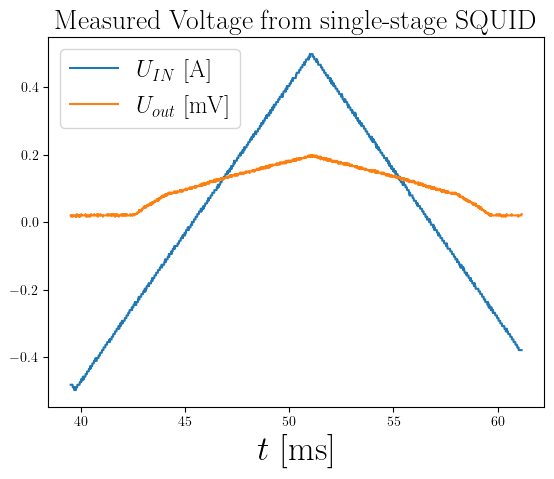

In [303]:
#Convert values into floats
time = data.iloc[:, 0].str.replace(',', '.', regex=False).astype(float).values  # [ms]
current= data.iloc[:, 1].str.replace(',', '.', regex=False).astype(float).values # [V]
current = current*8.7 #multply by resistance to get current
signal = data.iloc[:, 2].str.replace(',', '.', regex=False).astype(float).values # [mV]
signal = signal/1000

t_i = 17100
t_f = 19750
plt.plot(time1[t_i:t_f],current[t_i:t_f]/8.7, label =r"$U_{IN}$ [A]")
plt.plot(time1[t_i:t_f],signal[t_i:t_f], label =r"$U_{out}$ [mV]")
plt.title(r"Measured Voltage from single-stage SQUID", fontsize =20)
#plt.ylabel(r"$I$ [A]", fontsize = 20)
plt.xlabel(r"$t$ [ms]", fontsize = 25)

plt.legend( fontsize='xx-large', loc = 'best')
plt.show()

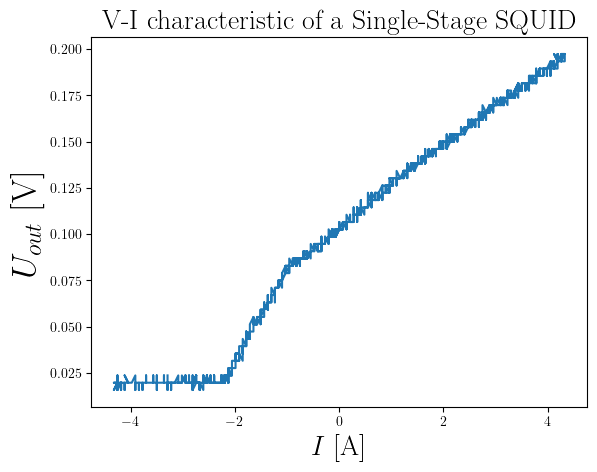

In [309]:
t_i = 17100
t_f = 19750

plt.plot(current[t_i:t_f],signal[t_i:t_f])
plt.title(r"V-I characteristic of a Single-Stage SQUID", fontsize =20)
plt.xlabel(r"$I$ [A]", fontsize = 20)
plt.ylabel(r"$U_{out}$ [V]", fontsize = 25)

#plt.legend( fontsize='xx-large', loc = 'best')
plt.show()

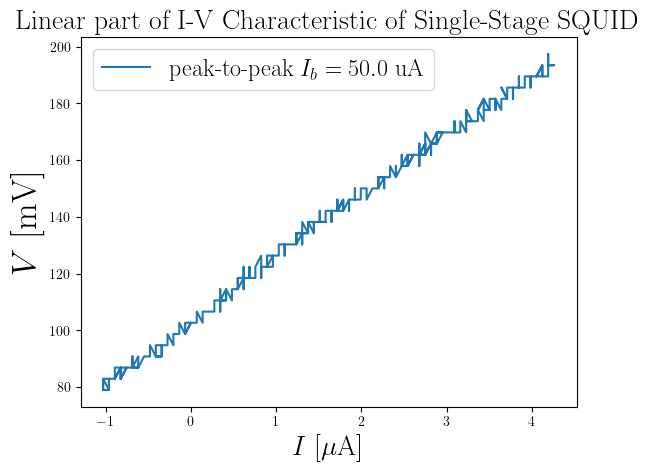

In [283]:
# plot signal
t_i = 17650
t_f = 18500
plt.plot(current[t_i:t_f],signal1[t_i:t_f], label =r"peak-to-peak $I_{b} = 50.0$ uA")
plt.title(r"Linear part of I-V Characteristic of Single-Stage SQUID", fontsize=20)
plt.xlabel(r"$I$ [$\mu$A]", fontsize = 20)
plt.ylabel(r"$V$ [mV]", fontsize = 25)
plt.legend( fontsize='xx-large', loc = 'best')
plt.show()

In [285]:
#we use Minuit package to fit a linear function to the measured signal
from iminuit import Minuit, cost
current_fit = current[t_i:t_f]
signal_fit = signal1[t_i:t_f]
sigma = np.ones_like(current_fit)
#since the measured signal has no uncertainties, we assume all residual to be equally weighted, therefore sigma_y = 1
# for all data point in the data set. 

def linear(x, t0,t1):
    return t0+t1*x

chi_2 = cost.LeastSquares(current_fit, signal_fit, sigma, model = linear)
linear.errordef = Minuit.LEAST_SQUARES
minuit = Minuit(chi_2, t0=103, t1=1.9)
minuit.migrad()
minuit.minos()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 3729 (χ²/ndof = 4.4)       │              Nfcn = 49               │
│ EDM = 3.4e-16 (Goal: 0.0002)     │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ t0   │  103.61   │   0.05    │   -0.05    │    0.05    │         │         │       │
│ 1 │ t1   │  21.846   │   0.022   │   -0.022   │   0.022    │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌──────────┬───────────────────────┬───────────────────────┐
│          │          t0           │          t1           │
├──────────┼───────────┬───────────┼───────────┬───────────┤
│  Error   │   -0.05   │   0.05    │  -0.022   │   0.022   │
│  Valid   │   True    │   True    │   True    │   True    │
│ At Limit │   False   │   False   │   False   │   False   │
│ Max FCN  │   False   │   False   │   False   │   False   │
│ New Min  │   False   │   False   │   False   │   False   │
└──────────┴───────────┴───────────┴───────────┴───────────┘
┌────┬───────────────────┐
│    │       t0       t1 │
├────┼───────────────────┤
│ t0 │  0.00247  -0.8e-3 │
│ t1 │  -0.8e-3 0.000502 │
└────┴───────────────────┘

<>:10: SyntaxWarning: invalid escape sequence '\p'
<>:10: SyntaxWarning: invalid escape sequence '\p'
C:\Users\magnu\AppData\Local\Temp\ipykernel_24584\3002228315.py:10: SyntaxWarning: invalid escape sequence '\p'
  label='linear Fit: \n $R$ = ({:.2f} $\pm$ 0.022) $\Omega$ '.format(t1_fit),


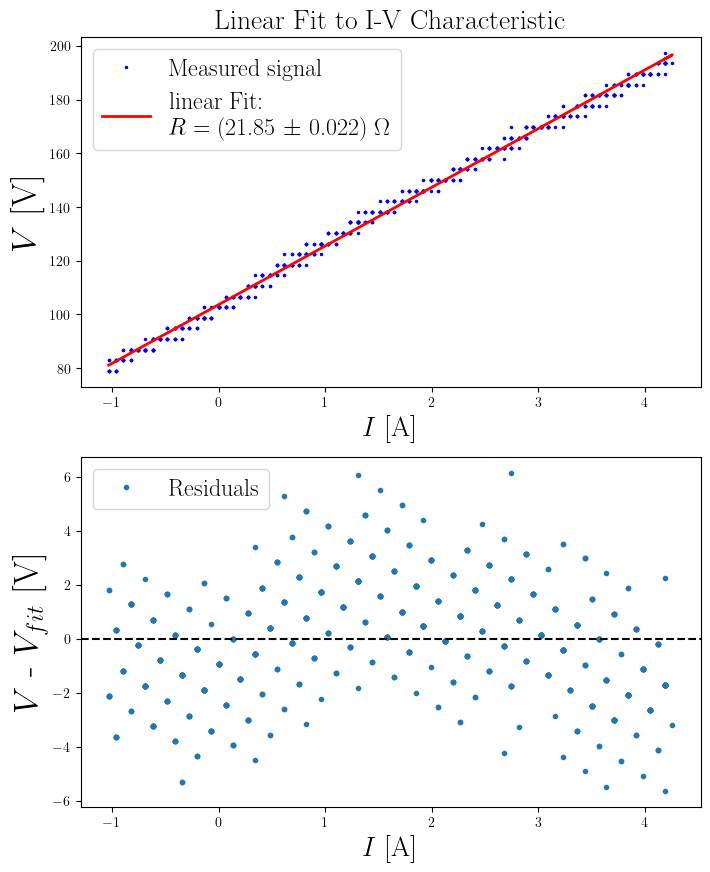

In [295]:
# Plot the data and the fitted model
import matplotlib.pyplot as plt
%matplotlib inline
t0_fit, t1_fit = minuit.values['t0'], minuit.values['t1']
fig, axs = plt.subplots(2, 1, figsize=(8,10))


axs[0].plot(current_fit, signal_fit,'b.', markersize=3, label = "Measured signal")
axs[0].plot(current_fit, linear(current_fit, t0_fit, t1_fit), '-', 
            label='linear Fit: \n $R$ = ({:.2f} $\pm$ 0.022) $\Omega$ '.format(t1_fit), 
            linewidth=2, color = "red")
axs[0].set_title(r"Linear Fit to I-V Characteristic", fontsize=20)
axs[0].set_xlabel(r"$I$ [A]", fontsize = 20)
axs[0].set_ylabel(r"$V$ [V]", fontsize=25)
axs[0].legend(fontsize='xx-large', loc='best')
#axs[0].grid(True)


#plot residuals
residuals = signal_fit - linear(current_fit, t0_fit, t1_fit)
axs[1].plot(current_fit, residuals, 'o', label="Residuals", markersize=3)
axs[1].axhline(0, color='black', linestyle='--')
#axs[1].set_title("Residuals of the Linear Fit", fontsize=20)
axs[1].set_xlabel(r"$I$ [A]", fontsize = 20)
axs[1].set_ylabel(r"$V$ - $V_{fit}$ [V]", fontsize=25)
axs[1].legend(fontsize='xx-large', loc='best')
#axs[1].grid(True)
plt.show()

We find that the resistance of a normal conducting Josephson Junction is:
$$G_N = ( 103.67 \pm 0.05)\, \textrm{m}\Omega $$

#### TODO : 
find critical current. Hint: I think is where the normal conducting behaviour beginns, however, We would get a negative current. I noted that we should modify the scale of the current axis.

In the next part of the experiment, we measure the voltage-flux characteristics of the single stage SQUID remaning in the open loop set-up. In Fig. 2 we present the measured singal for $\Phi_B$ and $\Phi_x$ along with the parameters we use to take the measurement. Here, $I_B$ is selected to maximaze the voltage swing (in $\mu$V) and $V_{B}$ to center the signal $V_{out}$ around 0 V. 

Fig. 2: Signal measured for (left) $V-\Phi_x$ characteristic and (right) Measured $V-\Phi_B$ characteristic and their parameters.
<div>
    <img src="Measurements/5.2/V_PhiX_max.png" alt="V_PhiB_Max.png"  width="45%" />
    <img src="Measurements/5.2/V_PhiB_Max.png" alt="V_PhiB_Max.png"  width="45%" />
</div>v>


Beside measuring the voltage-flux characteristics we also measured voltage at different integer fluxes. 

Tab. 1: Resistance of Channel 1
|  $\Phi /\Phi_0$  | $I_{\Phi_B}$ [$\mu$A]|$\Delta I_{\Phi_B}$ [$\mu$A] |
|------------------|----------------------|----------------------|
| n                |-26.04                | N.A                  |
| n+1              |15.75                 |41.79                 |
| n+2              |54.68                 |38.93                 |
| n+3              |98.47                 |43.79                 |


From the measured characteristics we aim to determine the inverse mutual inductance $M_{IN}^{-1}$,  $M_{\Phi_X}^{-1}$ and $M_{\Phi_B}^{-1}$. For this we use the know relations in Eq. 48 form the lab introduction. 
$$\Delta \Phi_i = \Delta I_i \cdot M$$
By measuring the difference between neighbouring flux quanta we get the relation:
$$M^{-1} = \frac{\Delta I_i}{\Phi_0}$$

From the measured flux-volta characteristic we can find the voltage swing between the minima and maxima, which represent the flux change of one flux quantum $\Phi_0  = 2.067 \cdot 10^{-15}$ Vs. 

In [145]:
phi_0 = 2.067e-15 #Vs
dI = np.array([41.79,38.93,43.79]) 
dI_mean = np.mean(dI)
dI_std = np.std(dI)
print(r"$\Delta$ I = {:.3} $\pm$ {:.2}".format(dI_mean, dI_std))

$\Delta$ I = 41.5 $\pm$ 2.0


In [27]:
#create a dataframe of saves file using pandas
data_phi = pd.read_csv("Measurements/5.2/V_PhiB/V_PhiB_1.csv", sep = ";", skiprows=[2], header=[0,1])
data_phi.head()

,Time,Channel A,Channel B
,(ms),(V),(mV)
0,"-23,85100722","-0,11844860","-4,75055300"
1,"-23,84895922","-0,11844860","-4,35531500"
2,"-23,84691122","-0,11844860","-3,95853800"
3,"-23,84486322","-0,11844860","-4,35531500"
4,"-23,84281522","-0,11844860","-4,75055300"


In [29]:
data_phix = pd.read_csv("Measurements/5.2/V_PhiX_1/V_PhiX_1.csv", sep = ";", skiprows=[2], header=[0,1])
data_phix.head()

,Time,Channel A,Channel B
,(ms),(V),(mV)
0,"-95,40671855","-0,42645790","13,85796000"
1,"-95,39855855","-0,42645790","14,25320000"
2,"-95,39039855","-0,42645790","14,25320000"
3,"-95,38223855","-0,42645790","14,25320000"
4,"-95,37407855","-0,42645790","15,44199000"


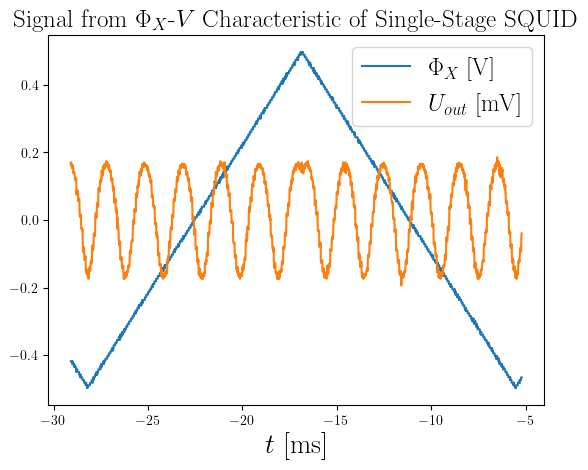

In [33]:
%matplotlib inline
#Convert values into floats
time_X = data_phix.iloc[:, 0].str.replace(',', '.', regex=False).astype(float).values  # [ms]
flux_X= data_phix.iloc[:, 1].str.replace(',', '.', regex=False).astype(float).values # [V]
signal_X = data_phix.iloc[:, 2].str.replace(',', '.', regex=False).astype(float).values # [mV]
signal_X = signal_X/100 #V

t_i = 8126
t_f = 11055
plt.plot(time_X[t_i:t_f],flux_X[t_i:t_f], label =r"$\Phi_X$ [V]")
plt.plot(time_X[t_i:t_f],signal_X[t_i:t_f], label =r"$U_{out}$ [mV]")
plt.title(r"Signal from $\Phi_X$-$V$ Characteristic of Single-Stage SQUID", fontsize =18)
plt.xlabel(r"$t$ [ms]", fontsize = 20)
#plt.ylabel(r"$V$ [mV]", fontsize = 25)
plt.legend( fontsize='xx-large', loc = 'best')
plt.show()

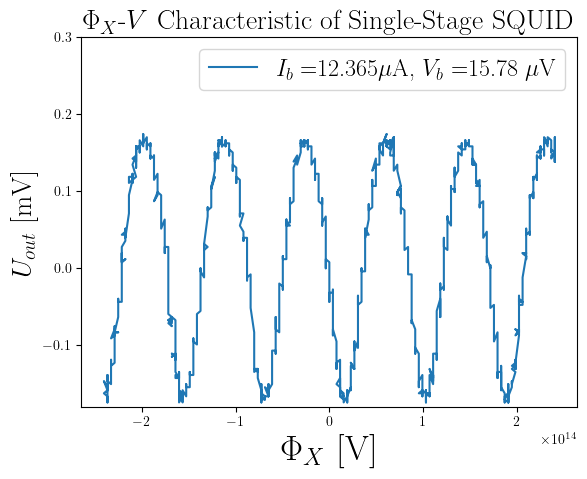

In [165]:
# plot signal
%matplotlib inline
import matplotlib.pyplot as plt
t_i = 8230
t_f = 9635
#plt.plot(time_X[t_i:t_f],flux_X[t_i:t_f], label =r"$I_{b} = 50.0$ $\mu$A")
plt.plot(flux_X[t_i:t_f]/phi_0,signal_X[t_i:t_f], label =r"$I_{b} = $12.365$\mu$A, $V_b$ =15.78 $\mu$V")
plt.title(r"$\Phi_X$-$V$ Characteristic of Single-Stage SQUID", fontsize=20)
plt.ylabel(r"$U_{out}$ [mV]", fontsize = 20)
plt.xlabel(r"$\Phi_X$ [V]", fontsize = 25)
plt.ylim(-0.18,0.30)
plt.legend( fontsize='xx-large', loc = 'best')
plt.show()

From the plot, we determine the voltage sing $\Delta V \sim 0.36$ mV.

We now use Eq. 47 $$M_ = \frac{\Delta U_{out}}{\Delta I_{\Phi_B}}$$
to find the resistance $R_F$. $I_{\Phi_B}$ represents the current we are placing in to the feed-back coil, given by the triangular pulse $I_{\Phi_B}$ $\in$ $[-0.15, 0.15]$ mA, which gives us a current difference $\Delta I_{\Phi_B} = 0.30$ mA

In [163]:
print("R_F = {:.3} Omega".format(0.36/0.3))

R_F = 1.2 Omega


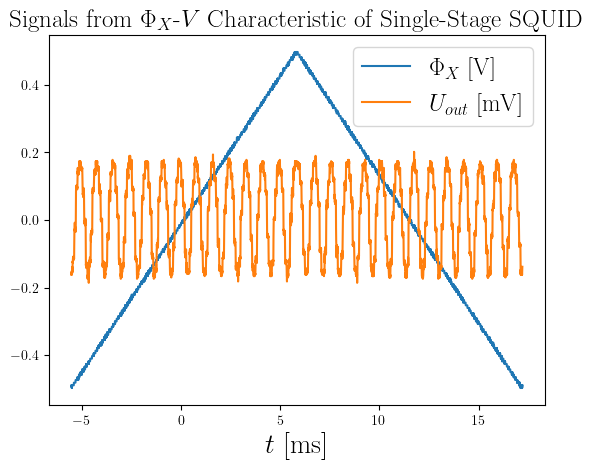

In [151]:
%matplotlib inline
time_B = data_phi.iloc[:, 0].str.replace(',', '.', regex=False).astype(float).values  # [ms]
flux_B= data_phi.iloc[:, 1].str.replace(',', '.', regex=False).astype(float).values # [V]
signal_B = data_phi.iloc[:, 2].str.replace(',', '.', regex=False).astype(float).values # [mV]
signal_B = signal_B/100 #V

t_i = 8950
t_f = 20050

plt.plot(time_B[t_i:t_f],flux_B[t_i:t_f], label =r"$\Phi_X$ [V]")
plt.plot(time_B[t_i:t_f],signal_B[t_i:t_f], label =r"$U_{out}$ [mV]")
plt.title(r"Signals from $\Phi_X$-$V$ Characteristic of Single-Stage SQUID", fontsize =18)
plt.xlabel(r"$t$ [ms]", fontsize = 20)
#plt.ylabel(r"$V$ [mV]", fontsize = 25)
plt.legend( fontsize='xx-large', loc = 'best')
plt.show()

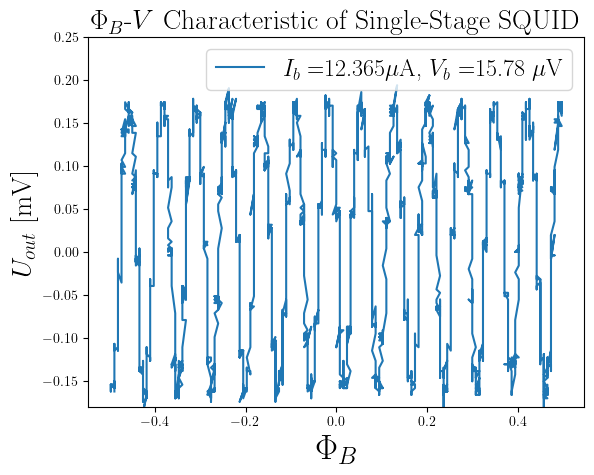

In [39]:

t_i = 8950
t_f = 14520
#plt.plot(time_X[t_i:t_f],flux_X[t_i:t_f], label =r"$I_{b} = 50.0$ $\mu$A")
plt.plot(flux_B[t_i:t_f],signal_B[t_i:t_f], label =r"$I_{b} = $12.365$\mu$A, $V_b$ =15.78 $\mu$V")
plt.title(r"$\Phi_B$-$V$ Characteristic of Single-Stage SQUID", fontsize=20)
plt.ylabel(r"$U_{out}$ [mV]", fontsize = 20)
plt.xlabel(r"$\Phi_B$ ", fontsize = 25)
plt.ylim(-0.18,0.25)
plt.legend( fontsize='xx-large', loc = 'best')
plt.show()

### 5.2.2 Flux Locked Loop

In the next section of the experiment, we analyze the SQUID in the FLL mode. For this we measure it's output signal resulting from a triangular signal. 

In [313]:
#create a dataframe of saves file using pandas
data = pd.read_csv("Measurements/5.2/FLL_workingpoint/FLL_workingpoint_2.csv", sep = ";", skiprows=[2], header=[0,1])
data.head()

,Time,Channel A,Channel B
,(ms),(V),(V)
0,"-95,40671855","-0,42645790","-0,04736713"
1,"-95,39855855","-0,42645790","-0,06317668"
2,"-95,39039855","-0,42645790","-0,06317668"
3,"-95,38223855","-0,42645790","-0,06317668"
4,"-95,37407855","-0,42645790","-0,06317668"


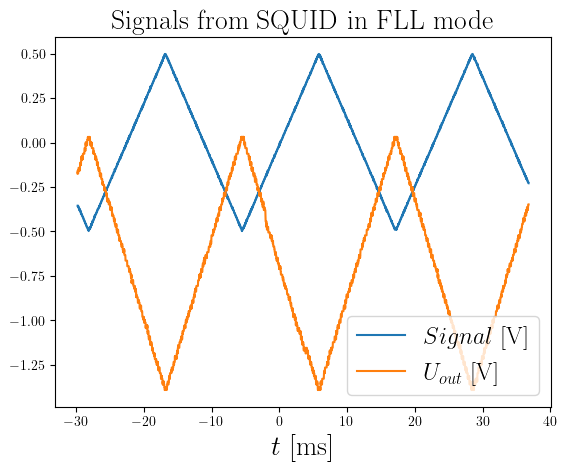

In [315]:
#Convert values into floats
time = data.iloc[:, 0].str.replace(',', '.', regex=False).astype(float).values  # [ms]
signal= data.iloc[:, 1].str.replace(',', '.', regex=False).astype(float).values # [V]
u_out = data.iloc[:, 2].str.replace(',', '.', regex=False).astype(float).values # [V]

t_i = 8039
t_f = 16201
plt.plot(time[t_i:t_f],signal[t_i:t_f], label =r"$Signal$ [V]")
plt.plot(time[t_i:t_f],u_out[t_i:t_f], label =r"$U_{out}$ [V]")
plt.title(r"Signals from SQUID in FLL mode", fontsize =20)
plt.xlabel(r"$t$ [ms]", fontsize = 20)
#plt.ylabel(r"$V$ [mV]", fontsize = 25)
plt.legend( fontsize='xx-large', loc = 'best')
plt.show()

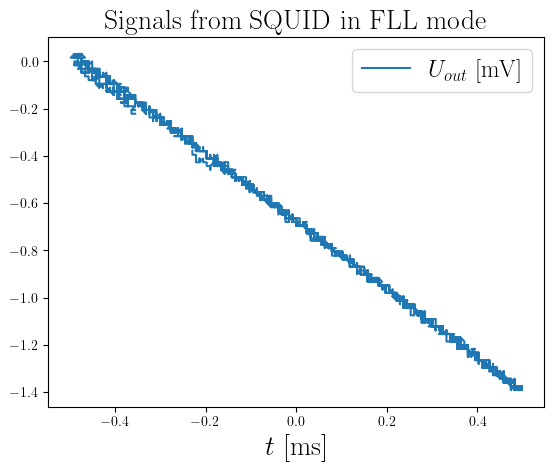

In [114]:
plt.plot(signal[t_i:t_f],u_out[t_i:t_f], label =r"$U_{out}$ [mV]")
plt.title(r"Signals from SQUID in FLL mode", fontsize =20)
plt.xlabel(r"$t$ [ms]", fontsize = 20)
#plt.ylabel(r"$V$ [mV]", fontsize = 25)
plt.legend( fontsize='xx-large', loc = 'best')
plt.show()

### 5.2.3 SQUID Noise

   <img src="Measurements/5.2/Spectrum.png" alt="Spectrum.png">